# Imports

In [115]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.math import reduce_mean
from tensorflow import convert_to_tensor, cast
import tensorflow.compat.v1 as tf
import tensorflow.keras.backend as bk

from model import plot_history, get_Xi_yi, get_X_y, get_folds, train_test_split_fold, MinMaxNormalization, savage_train_test_split
from cleaning import get_clean_bikes_dataframe
from utils import get_stations_info, get_live_status


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tensor_utils

In [116]:
import tensorflow.compat.v2 as tfc

from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import prefer_static

__all__ = [
    'convert_nonref_to_tensor',
    'discover_trainable_variables',
    'discover_variables',
    'identity_as_tensor',
    'is_module',
    'is_ref',
    'is_trainable_variable',
    'is_variable',
]


def convert_nonref_to_tensor(value, dtype=None, dtype_hint=None,
                             as_shape_tensor=False, name=None):
  """Converts the given `value` to a `Tensor` if input is nonreference type.
  This function converts Python objects of various types to `Tensor` objects
  only if the input has nonreference semantics. Reference semantics are
  characterized by `tensor_util.is_ref` and is any object which is a
  `tfc.Variable` or instance of `tfc.Module`. This function accepts any input
  which `tfc.convert_to_tensor` would also.
  Note: This function diverges from default Numpy behavior for `float` and
    `string` types when `None` is present in a Python list or scalar. Rather
    than silently converting `None` values, an error will be thrown.
  Args:
    value: An object whose type has a registered `Tensor` conversion function.
    dtype: Optional element type for the returned tensor. If missing, the
      type is inferred from the type of `value`.
    dtype_hint: Optional element type for the returned tensor,
      used when dtype is None. In some cases, a caller may not have a
      dtype in mind when converting to a tensor, so dtype_hint
      can be used as a soft preference.  If the conversion to
      `dtype_hint` is not possible, this argument has no effect.
    as_shape_tensor: Optional boolean when if `True` uses
      `prefer_static.convert_to_shape_tensor` instead of `tfc.convert_to_tensor`
      for JAX compatibility.
    name: Optional name to use if a new `Tensor` is created.
  Returns:
    tensor: A `Tensor` based on `value`.
  Raises:
    TypeError: If no conversion function is registered for `value` to `dtype`.
    RuntimeError: If a registered conversion function returns an invalid value.
    ValueError: If the `value` is a tensor not of given `dtype` in graph mode.
  #### Examples:
  ```python
  from tensorflow_probability.python.internal import tensor_util
  x = tfc.Variable(0.)
  y = tensor_util.convert_nonref_to_tensor(x)
  x is y
  # ==> True
  x = tfc.constant(0.)
  y = tensor_util.convert_nonref_to_tensor(x)
  x is y
  # ==> True
  x = np.array(0.)
  y = tensor_util.convert_nonref_to_tensor(x)
  x is y
  # ==> False
  tfc.is_tensor(y)
  # ==> True
  x = tfcp.util.DeferredTensor(13.37, lambda x: x)
  y = tensor_util.convert_nonref_to_tensor(x)
  x is y
  # ==> True
  tfc.is_tensor(y)
  # ==> True
  tfc.equal(y, 13.37)
  # ==> True
  ```
  """
  # We explicitly do not use a tfc.name_scope to avoid graph clutter.
  if value is None:
    return None
  if is_ref(value):
    if dtype is None:
      return value
    dtype_base = dtype_util.base_dtype(dtype)
    value_dtype_base = dtype_util.base_dtype(value.dtype)
    if dtype_base != value_dtype_base:
      raise TypeError('Mutable type must be of dtype "{}" but is "{}".'.format(
          dtype_util.name(dtype_base), dtype_util.name(value_dtype_base)))
    return value
  if as_shape_tensor:
    return prefer_static.convert_to_shape_tensor(
        value, dtype=dtype, dtype_hint=dtype_hint, name=name)
  return tfc.convert_to_tensor(
      value, dtype=dtype, dtype_hint=dtype_hint, name=name)


def identity_as_tensor(value):
  """Converts `value` to `Tensor` while ensuring an op is added to the graph."""
  t = tfc.convert_to_tensor(value)
  if t is value:
    t = tfc.identity(value)
  return t


def is_ref(x):
  """Evaluates if the object has reference semantics.
  An object is deemed "reference" if it is a `tfc.Variable` instance or is
  derived from a `tfc.Module` with `dtype` and `shape` properties.
  Args:
    x: Any object.
  Returns:
    is_ref: Python `bool` indicating input is has nonreference semantics, i.e.,
      is a `tfc.Variable` or a `tfc.Module` with `dtype` and `shape` properties.
  """
  # TODO(b/134430874): Consider making this recurse through nests, e.g.,
  # `tensor_util.is_ref([tfc.Variable(0.), np.array(1.)])`
  # returns True. Note: we'd need to actually create a tfc.Module on user's
  # behalf and it would need a `dtype` and `shape`. (I.e., there would be some
  # work to support this.)
  return (
      is_variable(x) or
      (is_module(x) and hasattr(x, 'dtype') and hasattr(x, 'shape'))
  )


def is_variable(x):
  """Returns `True` when input is a `tfc.Variable`, otherwise `False`."""
  return isinstance(x, tfc.Variable)


def is_trainable_variable(x):
  """Returns `True` when input is trainable `tfc.Variable`, otherwise `False`."""
  return is_variable(x) and getattr(x, 'trainable', False)


def is_module(x):
  """Returns `True` when input is a `tfc.Module`, otherwise `False`."""
  return isinstance(x, tfc.Module)


class _Track(tfc.Module):
  """Bridge to create functional interface for variable tracking."""

  def __init__(self, *args, **kwargs):
    self._args = args
    self._kwargs = kwargs


def discover_trainable_variables(x):
  """Returns `tuple` of all trainable `tfc.Variables` discoverable in input.
  Warning: unlike possibly `tfc.Module`, use of this function only does a static,
  "one-time" discovery. (This is self-evidently true from its functional
  nature.)
  Args:
    x: An object to inspected for `tfc.Variable` dependencies.
  Returns:
    trainable_vars: A Python `tuple` of `tfc.Variable`s with `trainable=True`.
  """
  return _Track(x).trainable_variables


def discover_variables(x):
  """Returns `tuple` of all `tfc.Variables` discoverable in input.
  Warning: unlike possibly `tfc.Module`, use of this function only does a static,
  "one-time" discovery. (This is self-evidently true from its functional
  nature.)
  Args:
    x: An object to inspected for `tfc.Variable` dependencies.
  Returns:
    vars: A Python `tuple` of `tfc.Variable`s, regardless of their value of
      `trainable`.
  """
  return _Track(x).variables

# Key cells

In [117]:
colab = False
station_sequence = False
diff = True 
folding = False

remove_hole = True
hole_threshold = "2022-06-11"
step = 5

In [118]:
nb_ts_per_hour = int(60 / step)
INPUT_LENGTH = 14 * 24 * nb_ts_per_hour # 14 days * 24 hours
OUTPUT_LENGTH = nb_ts_per_hour
SEQUENCE_STRIDE = 1

In [119]:
N_TRAIN = 10 # number_of_sequences_train
N_TEST =  5 # number_of_sequences_test

In [120]:
if colab :
    from google.colab import drive
    drive.mount('/content/drive')

# Data Loading

In [121]:
if colab :
    bikes_df = pd.read_csv('bikes_df.csv').drop(columns='Unnamed: 0')
else :
    bikes_df = get_clean_bikes_dataframe()

DataFrame successfully loaded from ~/.velov/data/cleaned/all_stations_hist.csv.


In [122]:
step_str = f'{step}min'

bikes_df=bikes_df.sort_values(by="time")
bikes_df['time']=pd.to_datetime(bikes_df['time'])
bikes_df = bikes_df.resample(step_str, on='time').mean()

if diff:
    for col in bikes_df.columns:
        bikes_df[col] = bikes_df[col].diff()
    bikes_df.dropna(inplace=True)

In [123]:
if remove_hole :
    bikes_df = bikes_df[bikes_df.index > hole_threshold]

In [124]:
# To verify normal distribution of diffs

#if diff:
#    bins = np.linspace(-39.75,39.75,num=80)
#    diffs = np.array(bikes_df).reshape(bikes_df.shape[0]*bikes_df.shape[1])
#    sns.histplot(diffs, bins=bins);

# Folding

In [125]:
FOLD_LENGTH = bikes_df.shape[0] # int(24 * 12 * 61) # 24 hours per day, 12 stamps per hour, 61 days
FOLD_STRIDE = 1 #int(24 * 12 * 7) # 1 week
TRAIN_TEST_RATIO = 0.7
print(FOLD_LENGTH, FOLD_STRIDE, INPUT_LENGTH)

26023 1 4032


In [126]:
if folding :
    bikes_folds = get_folds(bikes_df, FOLD_LENGTH, FOLD_STRIDE)
    bikes_fold = bikes_folds[0]

In [127]:
if folding :
    (bikes_fold_train, bikes_fold_test) = train_test_split_fold(bikes_fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

# Train/Test split


In [128]:
if folding :
    X_train_bikes, y_train_bikes = get_X_y(bikes_fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
    X_test_bikes, y_test_bikes = get_X_y(bikes_fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

    

else :
    X_train_bikes, y_train_bikes, X_test_bikes, y_test_bikes = savage_train_test_split(bikes_df,N_TRAIN,N_TEST,INPUT_LENGTH,OUTPUT_LENGTH)
    
X_train_bikes.shape, y_train_bikes.shape, X_test_bikes.shape, y_test_bikes.shape

((10, 4032, 430), (10, 12, 430), (5, 4032, 430), (5, 12, 430))

In [129]:
if station_sequence == True :
    # Pour passer en v Station = Sequence
    X_train_bikes = np.array(pd.DataFrame(X_train_bikes[0]).transpose())
    X_test_bikes = np.array(pd.DataFrame(X_test_bikes[0]).transpose())
    y_train_bikes = np.array(pd.DataFrame(y_train_bikes[0]).transpose())
    y_test_bikes = np.array(pd.DataFrame(y_test_bikes[0]).transpose())

    X_train_bikes = X_train_bikes.reshape((430,INPUT_LENGTH,1))
    X_test_bikes = X_test_bikes.reshape((430,INPUT_LENGTH,1))
    y_train_bikes = y_train_bikes.reshape((430,OUTPUT_LENGTH))
    y_test_bikes = y_test_bikes.reshape((430,OUTPUT_LENGTH))

    print(X_train_bikes.shape, y_train_bikes.shape, X_test_bikes.shape, y_test_bikes.shape) 


# Baseline Model 

In [130]:
if not diff:
    y_base_bikes = []
    for i in range(y_test_bikes.shape[0]):
        y_base_bikes.append([X_test_bikes[i,-1:,:]]*y_test_bikes.shape[1])

    y_base_bikes = np.array(y_base_bikes).reshape((y_test_bikes.shape[0],y_test_bikes.shape[1],y_test_bikes.shape[2]))
    y_base_bikes.shape

In [131]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError

mse_base = MeanSquaredError()
mae_base = MeanAbsoluteError()
rmse_base = RootMeanSquaredError(name = 'rmse')

if diff:
    mae = round(np.abs(y_test_bikes).mean(),4)
    mse = mse_base(y_test_bikes,np.zeros(shape=y_test_bikes.shape))
    rmse = rmse_base(y_test_bikes,np.zeros(shape=y_test_bikes.shape))
else :
    mae = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
    mse = mse_base(y_test_bikes,y_base_bikes)
    rmse = rmse_base(y_test_bikes,y_base_bikes)


Baseline MSE : 0.2837827503681183 // Baseline RMSE : 0.5327126383781433
Baseline MAE : 0.1684
[0.1264, 0.1366, 0.1353, 0.1455, 0.142, 0.148, 0.1467, 0.1497, 0.2418, 0.2849, 0.1837, 0.1798]


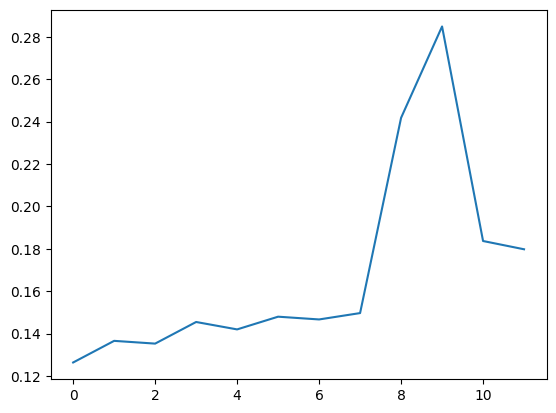

In [132]:
maes = []

for i in range(y_test_bikes.shape[1]):
    if diff:
        maes.append(np.round(np.abs(y_test_bikes[:,i,:]).mean(),4))
    else:
        maes.append(np.round(np.abs(y_test_bikes[:,i,:]-y_base_bikes[:,i,:]).mean(),2))

print(f"Baseline MSE : {mse} // Baseline RMSE : {rmse}\nBaseline MAE : {mae}")
print(maes)
plt.plot(maes);

# Scaling and scoring the Baseline on scaled

In [133]:
"""
if not diff:
    scaler = MinMaxNormalization()
    scaler.fit_transform(X_train_bikes)
    #scaler.transform(y_train_bikes)
    scaler.transform(X_test_bikes)
    #scaler.transform(y_test_bikes)
    print(f"X_train : Shape {X_train_bikes.shape}, min {X_train_bikes.min()}, max {X_train_bikes.max()}")
    print(f"y_train : Shape {y_train_bikes.shape}, min {y_train_bikes.min()}, max {y_train_bikes.max()}")
    print(f"X_test : Shape {X_test_bikes.shape}, min {X_test_bikes.min()}, max {X_test_bikes.max()}")
    print(f"y_test : Shape {y_test_bikes.shape}, min {y_test_bikes.min()}, max {y_test_bikes.max()}")
"""

'\nif not diff:\n    scaler = MinMaxNormalization()\n    scaler.fit_transform(X_train_bikes)\n    #scaler.transform(y_train_bikes)\n    scaler.transform(X_test_bikes)\n    #scaler.transform(y_test_bikes)\n    print(f"X_train : Shape {X_train_bikes.shape}, min {X_train_bikes.min()}, max {X_train_bikes.max()}")\n    print(f"y_train : Shape {y_train_bikes.shape}, min {y_train_bikes.min()}, max {y_train_bikes.max()}")\n    print(f"X_test : Shape {X_test_bikes.shape}, min {X_test_bikes.min()}, max {X_test_bikes.max()}")\n    print(f"y_test : Shape {y_test_bikes.shape}, min {y_test_bikes.min()}, max {y_test_bikes.max()}")\n'

In [134]:
"""
if not diff:
    #scaler.transform(y_base_bikes)
    mae_sc = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
    mse_sc = mse_base(y_test_bikes,y_base_bikes)
    rmse_sc = rmse_base(y_test_bikes,y_base_bikes)
    print(f"Baseline MSE on scaled data : {mse_sc} // Baseline RMSE on scaled data : {rmse_sc}\nBaseline MAE on scaled data: {mae_sc}")
"""

'\nif not diff:\n    #scaler.transform(y_base_bikes)\n    mae_sc = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)\n    mse_sc = mse_base(y_test_bikes,y_base_bikes)\n    rmse_sc = rmse_base(y_test_bikes,y_base_bikes)\n    print(f"Baseline MSE on scaled data : {mse_sc} // Baseline RMSE on scaled data : {rmse_sc}\nBaseline MAE on scaled data: {mae_sc}")\n'

# Custom Loss to penalize more later predictions (and keep the baseline for early preditctions)

In [135]:
low_threshold = 12
high_threshold = 12
penalization = 4

def make_custom_mae(batch_size:int, low_threshold:int=1_000_000_000_000, high_threshold:int=1_000_000_000_000):
    def custom_mae(y_true, y_pred):
        y_true = cast(y_true, y_pred.dtype)
        error = (y_true - y_pred).numpy()
        for i in range(error.shape[1]):
            if i < high_threshold :
                error[:,i,:] = np.abs(error[:,i,:])
            else :
                pass # Keeps error to 0   
        np_error = convert_nonref_to_tensor(error)   
        return bk.mean(bk.mean(bk.mean(np_error, axis=2),axis=1),axis=0)
    return custom_mae

def make_custom_mse(batch_size:int, low_threshold:int=1_000_000_000_000, high_threshold:int=1_000_000_000_000):
    def custom_mse(y_true, y_pred):
        y_true = cast(y_true, y_pred.dtype)
        #print(y_true.shape, type(y_true))
        #print(y_pred.shape, type(y_pred))
        error = (y_true - y_pred).numpy()
        tf_error = tf.Variable(error)        
        #print(error.shape, type(error))        
        for i in range(error.shape[1]):
            if i < low_threshold:
                error[:,i,:] = error[:,i,:] ** 2
            elif i < high_threshold :
                error[:,i,:] = error[:,i,:] ** 2 * penalization
            else :
                pass # Keeps error to 0   
        #print(reduce_mean(reduce_mean(reduce_mean(np_error, axis=-1),axis=1),axis=0))    
        return bk.mean(bk.mean(bk.mean(tf_error, axis=2),axis=1),axis=0)
    return custom_mse

In [136]:
# Cell to test the validity of the custom loss function (do not forget to adjust thresholds)
"""from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

test_int = 32

y_cust_loss_test_a = convert_nonref_to_tensor(y_test_bikes[:test_int,:,:])
y_cust_loss_test_b = convert_nonref_to_tensor(y_train_bikes[:test_int,:,:])

mse_base = MeanSquaredError()
mae_base = MeanAbsoluteError()
custom_mse = make_custom_mse(test_int)
custom_mae = make_custom_mae(test_int)

print(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)} / MAE Base: {mae_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MAE Custom: {custom_mae(y_cust_loss_test_a, y_cust_loss_test_b)}")
#print(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)}")
"""


'from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError\n\ntest_int = 32\n\ny_cust_loss_test_a = convert_nonref_to_tensor(y_test_bikes[:test_int,:,:])\ny_cust_loss_test_b = convert_nonref_to_tensor(y_train_bikes[:test_int,:,:])\n\nmse_base = MeanSquaredError()\nmae_base = MeanAbsoluteError()\ncustom_mse = make_custom_mse(test_int)\ncustom_mae = make_custom_mae(test_int)\n\nprint(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)} / MAE Base: {mae_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MAE Custom: {custom_mae(y_cust_loss_test_a, y_cust_loss_test_b)}")\n#print(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)}")\n'

# Modelling

### Loss function parameters 

In [137]:
low_t = 10000000
high_t = nb_ts_per_hour
batch_size= 32

### Not Diff

In [138]:
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps = decay_steps, decay_rate = decay_rate,)

def init_model(X_train, y_train):

    model = Sequential([
        layers.GRU(units=256, input_shape = (X_train.shape[1],X_train.shape[2]), activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.GRU(units=256, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(512,activation = 'relu'),
        layers.Lambda(lambda x:x[:,:high_t,:]),
        #layers.Dropout(0.2),
        #layers.Dense(64,activation = 'relu'),
        #layers.Dense(64,activation = 'relu'),
        layers.Dense(y_train.shape[2], activation='linear')  
    ])

    optimizer=Adam(learning_rate=lr_schedule)

    model.compile(optimizer='rmsprop',
                #loss=make_custom_mse(batch_size,low_threshold=low_t, high_threshold=high_t),
                loss = 'mse',
                #run_eagerly=True,
                metrics = [rmse_base,'mae']
                )
    
    return model

### Diff

In [139]:
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps = decay_steps, decay_rate = decay_rate,)

def init_diff_model(X_train, y_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = Sequential([
        normalizer,
        layers.GRU(units=512, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        layers.GRU(units=64, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(512,activation = 'relu'),
        layers.Lambda(lambda x:x[:,:high_t,:]),
        #layers.Dropout(0.2),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(y_train.shape[2], activation='linear')  
    ])
    
    model.compile(optimizer='rmsprop',
                loss='mse',
                #loss=make_custom_mse(batch_size, low_threshold=low_t, high_threshold=high_t),
                #run_eagerly = True,
                metrics=[rmse_base,'mae'])
    return model

### All

In [140]:
if diff:
    model = init_diff_model(X_train_bikes, y_train_bikes)
else :
    model = init_model(X_train_bikes, y_train_bikes)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 430)        861       
 ion)                                                            
                                                                 
 gru_2 (GRU)                 (None, None, 512)         1449984   
                                                                 
 gru_3 (GRU)                 (None, None, 64)          110976    
                                                                 
 dense_4 (Dense)             (None, None, 512)         33280     
                                                                 
 lambda_1 (Lambda)           (None, None, 512)         0         
                                                                 
 dense_5 (Dense)             (None, None, 64)          32832     
                                                      

In [141]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model,X,y):
    es = EarlyStopping(patience=2,restore_best_weights = True)
    history = model.fit(X,y,epochs = 4,callbacks=es,batch_size=batch_size, validation_split=0.3)
    return(model,history)

In [142]:
print(f"Baseline MSE : {mse} // Baseline RMSE : {rmse}\nBaseline MAE : {mae}")

Baseline MSE : 0.2837827503681183 // Baseline RMSE : 0.5327126383781433
Baseline MAE : 0.1684


In [143]:
model,history = fit_model(model,X_train_bikes,y_train_bikes)


Epoch 1/4
1/1 [==============================] - 20s 20s/step - loss: 0.2995 - rmse: 0.5413 - mae: 0.2201 - val_loss: 0.6282 - val_rmse: 0.7926 - val_mae: 0.4186
Epoch 2/4
1/1 [==============================] - 16s 16s/step - loss: 0.2977 - rmse: 0.5456 - mae: 0.2235 - val_loss: 0.6285 - val_rmse: 0.7928 - val_mae: 0.4208
Epoch 3/4
1/1 [==============================] - 16s 16s/step - loss: 0.2950 - rmse: 0.5432 - mae: 0.2289 - val_loss: 0.6287 - val_rmse: 0.7929 - val_mae: 0.4229


In [144]:
res =model.evaluate(X_test_bikes,y_test_bikes)

1/1 [==============================] - 4s 4s/step - loss: 0.2839 - rmse: 0.5328 - mae: 0.1795


In [145]:
y_pred = model.predict(X_test_bikes)

1/1 [==============================] - 4s 4s/step


0.1795
[0.13190481103114174, 0.14552271719870713, 0.14581552498368186, 0.1564446239875803, 0.15445567569761473, 0.15954785009982902, 0.15786166428938841, 0.16197811240566057, 0.25384694250090795, 0.2970665915996746, 0.19588747603912268, 0.19328413727819602]


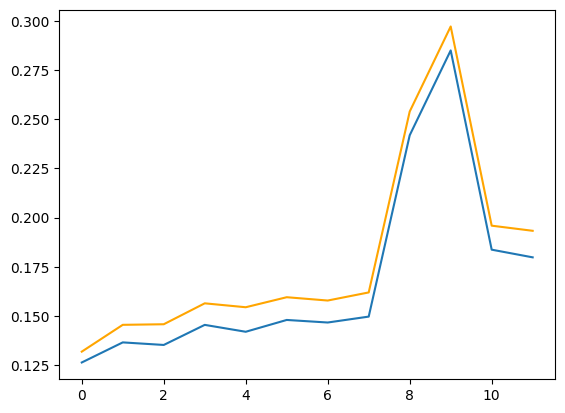

In [146]:

if not diff :
    scaler.inverse_transform(y_test_bikes)
    scaler.inverse_transform(y_pred)        

model_mae = round(np.abs(y_test_bikes-y_pred).mean(),4)

model_maes = []
for i in range(y_pred.shape[1]):
    model_maes.append(np.abs(y_test_bikes[:,i,:]-y_pred[:,i,:]).mean())

print(model_mae)
print(model_maes)
plt.plot(model_maes, color='orange');
plt.plot(maes);

In [147]:
y_pred.shape

(5, 12, 430)

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

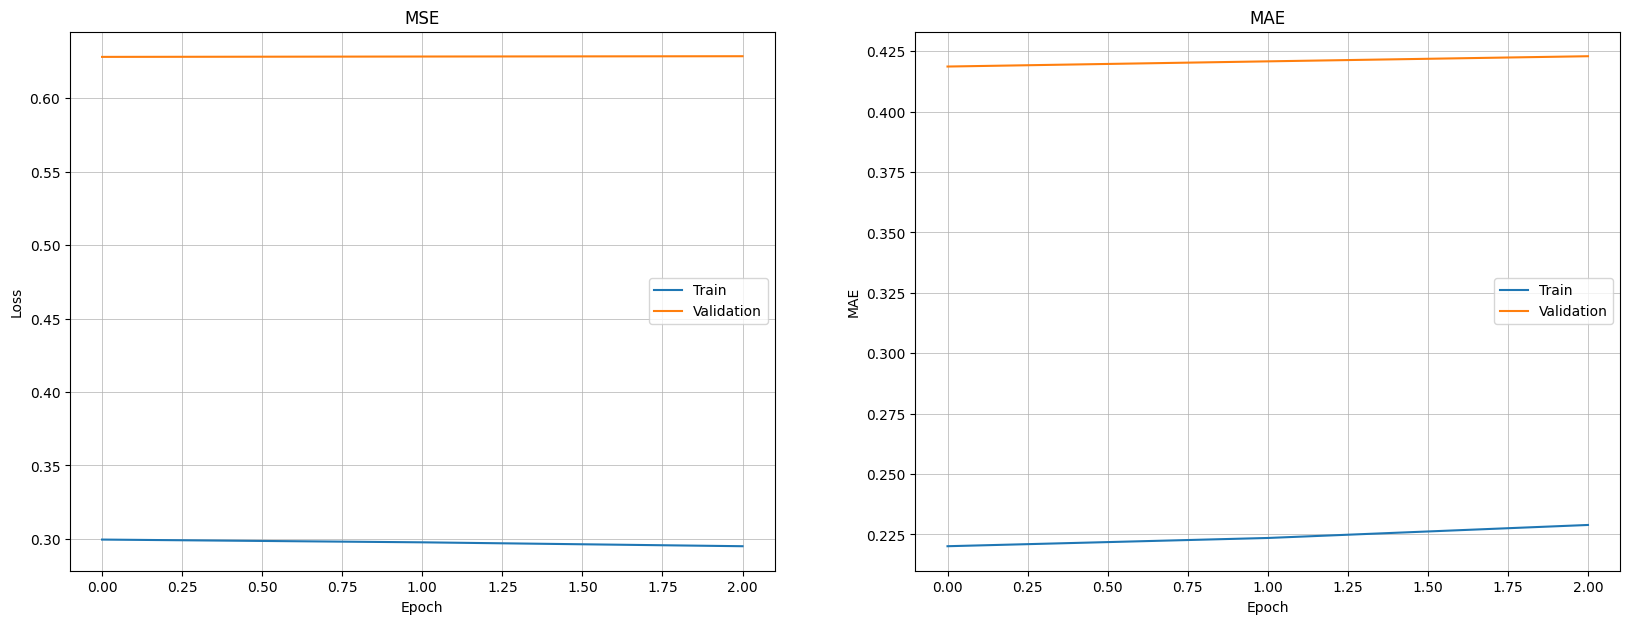

In [148]:
plot_history(history)

In [149]:
def prediction():
    X_pred = np.array([np.array(get_live_status()[['bikes','station_number']].set_index('station_number'))]*12)
    X_pred = X_pred.reshape((X_pred.shape[0],X_pred.shape[1]))
    y_pred_diff=model.predict(X_pred)
    y_pred_diff = y_pred_diff.reshape((y_pred_diff.shape[1],y_pred_diff.shape[2]))
    y_pred = X_pred + y_pred_diff
    output_dict=pd.DataFrame(y_pred).to_dict()
    return output_dict

In [150]:
prediction()

1/1 [==============================] - 1s 613ms/step


{0: {0: 20.988163576461375,
  1: 20.980309408158064,
  2: 20.972248014062643,
  3: 20.967928744852543,
  4: 20.963809601962566,
  5: 20.96004245430231,
  6: 20.957404755055904,
  7: 20.95549575984478,
  8: 20.953771501779556,
  9: 20.95239856094122,
  10: 20.951415069401264,
  11: 20.950566932559013},
 1: {0: 9.966534607112408,
  1: 9.961151495575905,
  2: 9.958332724869251,
  3: 9.956387981772423,
  4: 9.95530766993761,
  5: 9.955662049353123,
  6: 9.955845519900322,
  7: 9.955492615699768,
  8: 9.954924263060093,
  9: 9.954507201910019,
  10: 9.954270906746387,
  11: 9.954075925052166},
 2: {0: 9.027600944042206,
  1: 9.040350452065468,
  2: 9.047118369489908,
  3: 9.050670228898525,
  4: 9.052869390696287,
  5: 9.054426722228527,
  6: 9.055914666503668,
  7: 9.05714413523674,
  8: 9.058247730135918,
  9: 9.059205319732428,
  10: 9.059960220009089,
  11: 9.060649015009403},
 3: {0: 18.010520880110562,
  1: 18.006709993816912,
  2: 18.004425467923284,
  3: 18.004364743828773,
  4: 18.

In [151]:
model_save = False 

if model_save :
    with open("pipeline.pkl", "wb") as file:
        pickle.dump(pipeline_tuned, file)